## 1. Building the TF-IDF matrix.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

comp_subclasses = ['comp.graphics', 
                        'comp.os.ms-windows.misc', 
                        'comp.sys.ibm.pc.hardware', 
                        'comp.sys.mac.hardware']

rec_subclasses = ['rec.autos', 
                      'rec.motorcycles', 
                      'rec.sport.baseball', 
                      'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=comp_subclasses+rec_subclasses,
                             shuffle = True,
                             random_state=42)

labels = [1 if t >= 4 else 0 for t in dataset.target]

In [2]:
count_vectorizer = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS, min_df=3)
dataset_counts = count_vectorizer.fit_transform(dataset.data)

tfidf_transformer = TfidfTransformer()
tfidf_dataset = tfidf_transformer.fit_transform(dataset_counts)
tfidf_dataset.shape

(7882, 27768)

## 2. Apply K-means clustering with k = 2 using the TF-IDF data.

In [5]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=1)
km.fit(tfidf_dataset)

def contingency_matrix(labels, km_labels):
    #
    # suppose the X belongs the class1 and O belongs the class2, so the value of X is 0, the value of O is 1 in the labels and km_labels
    # class1_O, class1_X, class2_O, class2_X are the predicted result.
    class1_O = 0 
    class2_O = 0 
    for i,j in zip(labels, km_labels):
        if j == 0: # clustering class 1
            class1_O += i 
        elif j == 1: # clustering class 2
            class2_O += i 
    class2_X = np.sum(km_labels) - class2_O # np.sum(km_labels) is the number of the element in the predicted Class2  
    class1_X = len(labels) - np.sum(km_labels) - class1_O
    
    print("===================================")
    print("contingency_matrix|   O   |   X")
    print("-----------------------------------")
    print("Class1            |{:^7}|{:^7}".format(class1_O, class1_X))
    print("Class2            |{:^7}|{:^7}".format(class2_O, class2_X))
    return class1_O, class1_X, class2_O, class2_X

print("Homogeneity: %0.5f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.5f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.5f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand score: %0.5f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted Mutual Info Score: %0.5f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))
contingency_matrix(labels, km.labels_)

Homogeneity: 0.80085
Completeness: 0.80119
V-measure: 0.80102
Adjusted Rand score: 0.87904
Adjusted Mutual Info Score: 0.80084
contingency_matrix|   O   |   X
-----------------------------------
Class1            |  91   | 3748  
Class2            | 3888  |  155  


(91, 3748, 3888, 155)

In [6]:
contingency_matrix([0,1,1,0,1,0,0,0,1,1], [0,0,0,0,0,0,0,1,1,1])

contingency_matrix|   O   |   X
-----------------------------------
Class1            |   3   |   4   
Class2            |   2   |   1   


(3, 4, 2, 1)

## 3. Preprocess the data

### (a) Dimensionality reduction

**Calculating singular values**

In [7]:
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
u, singular_values, vt = svds(tfidf_dataset, 1000)
singular_values = singular_values[::-1]
# print('Top',num_of_singular_values,'singular values are:')
# print(singular_values[::-1])

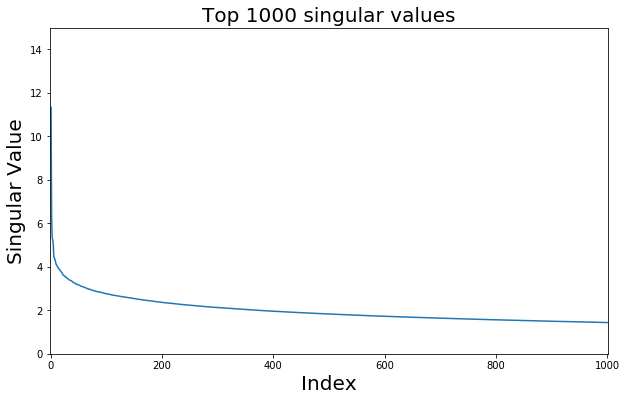

In [8]:
plt.figure(figsize = (10,6))
plt.plot(range(1,1001), singular_values)
plt.ylabel('Singular Value', fontsize = 20)
plt.xlabel('Index', fontsize = 20)
plt.title('Top 1000 singular values', fontsize = 20)
plt.axis([-1,1001,0,15])
plt.show()

**the percent of variance the top $r$ principal components**

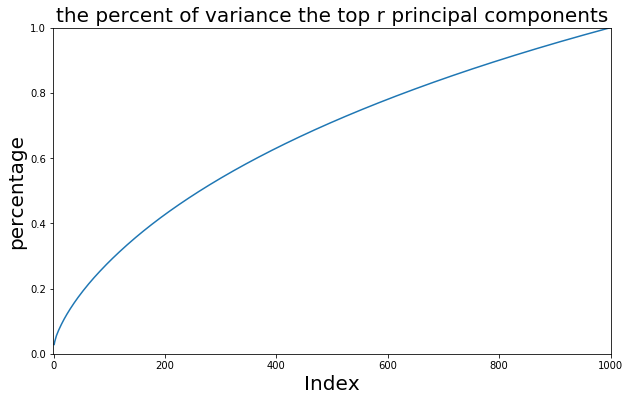

In [9]:
total = np.sum(singular_values*singular_values)# singular_values matrix is the Diagonal matrix
ratio = []
retained_value = 0
for r in range(1000):
    retained_value = retained_value + singular_values[r]*singular_values[r]
    ratio.append(retained_value/total)    

plt.figure(figsize = (10,6))
plt.plot(range(1,1001), ratio)
plt.ylabel('percentage', fontsize = 20)
plt.xlabel('Index', fontsize = 20)
plt.title('the percent of variance the top r principal components', fontsize = 20)
plt.axis([-1,1001,0,1])
plt.show()

**Truncated SVD (LSI) / PCA**

In [10]:
from sklearn.decomposition import TruncatedSVD

r_values = [1, 2, 3, 5, 10, 20, 50, 100, 300]

for r in r_values:
    SVD = TruncatedSVD(n_components=r, random_state=42) 
    transformed_tfidf = SVD.fit_transform(tfidf_dataset)
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
    km.fit(transformed_tfidf)
    print("="*30,"r =", r, "="*30)
    print("Homogeneity: %0.5f" % metrics.homogeneity_score(labels, km.labels_))
    print("Completeness: %0.5f" % metrics.completeness_score(labels, km.labels_))
    print("V-measure: %0.5f" % metrics.v_measure_score(labels, km.labels_))
    print("Adjusted Rand score: %.5f" % metrics.adjusted_rand_score(labels, km.labels_))
    print("Adjusted Mutual Info Score: %0.5f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))
    contingency_matrix(labels, km.labels_)

============================== r = 1 ==============================
Homogeneity: 0.00030
Completeness: 0.00030
V-measure: 0.00030
Adjusted Rand score: 0.00034
Adjusted Mutual Info Score: 0.00021
contingency_matrix|   O   |   X
-----------------------------------
Class1            | 2323  | 2200  
Class2            | 1656  | 1703  
============================== r = 2 ==============================
Homogeneity: 0.58271
Completeness: 0.58487
V-measure: 0.58379
Adjusted Rand score: 0.68003
Adjusted Mutual Info Score: 0.58267
contingency_matrix|   O   |   X
-----------------------------------
Class1            |  507  | 3719  
Class2            | 3472  |  184  
============================== r = 3 ==============================
Homogeneity: 0.39121
Completeness: 0.43190
V-measure: 0.41055
Adjusted Rand score: 0.38011
Adjusted Mutual Info Score: 0.39115
contingency_matrix|   O   |   X
-----------------------------------
Class1            | 2500  |  32   
Class2            | 1479  | 3871  
=

In [11]:
from sklearn.decomposition import NMF

for r in r_values:
    trainNMF = NMF(n_components=r, init='random', random_state=42)
    NMF_dataset = trainNMF.fit_transform(tfidf_dataset)
    km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
    km.fit(NMF_dataset)
    print("="*30,"r =", r, "="*30)
    print("Homogeneity: %0.5f" % metrics.homogeneity_score(labels, km.labels_))
    print("Completeness: %0.5f" % metrics.completeness_score(labels, km.labels_))
    print("V-measure: %0.5f" % metrics.v_measure_score(labels, km.labels_))
    print("Adjusted Rand score: %.5f" % metrics.adjusted_rand_score(labels, km.labels_))
    print("Adjusted Mutual Info Score: %0.5f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))
    contingency_matrix(labels, km.labels_)

============================== r = 1 ==============================
Homogeneity: 0.00030
Completeness: 0.00030
V-measure: 0.00030
Adjusted Rand score: 0.00034
Adjusted Mutual Info Score: 0.00021
contingency_matrix|   O   |   X
-----------------------------------
Class1            | 2313  | 2190  
Class2            | 1666  | 1713  
============================== r = 2 ==============================
Homogeneity: 0.58058
Completeness: 0.59753
V-measure: 0.58893
Adjusted Rand score: 0.63194
Adjusted Mutual Info Score: 0.58054
contingency_matrix|   O   |   X
-----------------------------------
Class1            |  33   | 3128  
Class2            | 3946  |  775  
============================== r = 3 ==============================
Homogeneity: 0.02782
Completeness: 0.15578
V-measure: 0.04721
Adjusted Rand score: 0.00393
Adjusted Mutual Info Score: 0.02773
contingency_matrix|   O   |   X
-----------------------------------
Class1            | 3979  | 3691  
Class2            |   0   |  212  
=

## 4. 
(a) Visualize the performance of the case with best clustering results in the previous part your clustering by projecting final data vectors onto 2 dimensional plane and color-coding the classes.

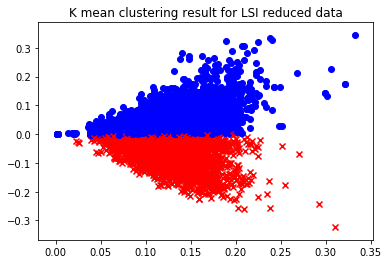

In [12]:
SVD = TruncatedSVD(n_components=2, random_state=42) 
transformed_tfidf = SVD.fit_transform(tfidf_dataset)
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(transformed_tfidf)

plt.title("K mean clustering result for LSI reduced data")
for i in range(len(transformed_tfidf[:, 0])):
    if km.labels_[i] == 0:
        plt.scatter(transformed_tfidf[i, 0], transformed_tfidf[i, 1], c='r',
                    marker='x')
    elif km.labels_[i] == 1:
        plt.scatter(transformed_tfidf[i, 0], transformed_tfidf[i, 1], c='b',
                    marker='o')
plt.show()

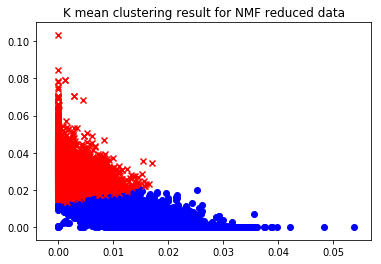

In [13]:
trainNMF = NMF(n_components=2, init='random', random_state=42)
NMF_dataset = trainNMF.fit_transform(tfidf_dataset)
km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(NMF_dataset)

plt.title("K mean clustering result for NMF reduced data")
for i in range(len(NMF_dataset[:, 0])):
    if km.labels_[i] == 0:
        plt.scatter(NMF_dataset[i, 0], NMF_dataset[i, 1], c='r',
                    marker='x')
    elif km.labels_[i] == 1:
        plt.scatter(NMF_dataset[i, 0], NMF_dataset[i, 1], c='b',
                    marker='o')
plt.show()

(b). Visualize the transformed data as in part (a). Report the new clustering measures including the contingency matrix after transformation

**StandardScaler then Log**

Homogeneity: 0.19328
Completeness: 0.29319
V-measure: 0.23297
Adjusted Rand score: 0.10989
Adjusted Mutual Info Score: 0.19320
contingency_matrix|   O   |   X
-----------------------------------
Class1            | 1345  |   0   
Class2            | 2634  | 3903  


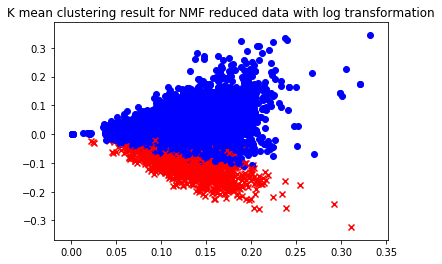

In [14]:
from sklearn.preprocessing import Normalizer, FunctionTransformer,StandardScaler
from sklearn.pipeline import make_pipeline

def addSmallThenLog(X):
    return np.log(X+0.001)

# Preprocessing
numberOfComponents = 2
LSIModel = TruncatedSVD(n_components=numberOfComponents, random_state=42) # LSI
NMFModel = NMF(n_components=numberOfComponents, random_state=42) # NMF
normalizer = StandardScaler(copy=False, with_mean=False)
LogTransformation = FunctionTransformer(func=addSmallThenLog)

# Put the preprocessing steps here
NMF_pipe = make_pipeline(NMFModel, normalizer, LogTransformation)

dataset_NMF = NMF_pipe.fit_transform(tfidf_dataset)

km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(dataset_NMF)

print("Homogeneity: %0.5f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.5f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.5f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand score: %.5f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted Mutual Info Score: %0.5f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))
contingency_matrix(labels, km.labels_)

plt.title("K mean clustering result for NMF reduced data with log transformation")
for i in range(len(transformed_tfidf[:, 0])):
    if km.labels_[i] == 0:
        plt.scatter(transformed_tfidf[i, 0], transformed_tfidf[i, 1], c='r',
                    marker='x')
    elif km.labels_[i] == 1:
        plt.scatter(transformed_tfidf[i, 0], transformed_tfidf[i, 1], c='b',
                    marker='o')
plt.show()

**Log then StandardScaler**

Homogeneity: 0.71022
Completeness: 0.71096
V-measure: 0.71059
Adjusted Rand score: 0.80500
Adjusted Mutual Info Score: 0.71019
contingency_matrix|   O   |   X
-----------------------------------
Class1            | 3835  |  261  
Class2            |  144  | 3642  


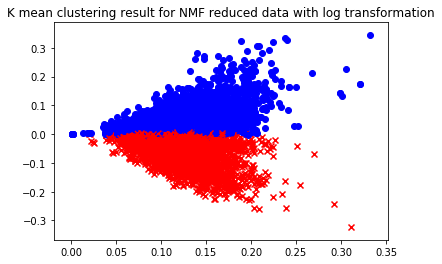

In [15]:
NMF_pipe = make_pipeline(NMFModel, LogTransformation, normalizer)

dataset_NMF = NMF_pipe.fit_transform(tfidf_dataset)

km = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
km.fit(dataset_NMF)

print("Homogeneity: %0.5f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.5f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.5f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand score: %.5f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Adjusted Mutual Info Score: %0.5f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))
contingency_matrix(labels, km.labels_)

plt.title("K mean clustering result for NMF reduced data with log transformation")
for i in range(len(transformed_tfidf[:, 0])):
    if km.labels_[i] == 0:
        plt.scatter(transformed_tfidf[i, 0], transformed_tfidf[i, 1], c='r',
                    marker='x')
    elif km.labels_[i] == 1:
        plt.scatter(transformed_tfidf[i, 0], transformed_tfidf[i, 1], c='b',
                    marker='o')
plt.show()

## 5. Expand Dataset into 20 categories